In [1]:
# Imports

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Answer the questions below by using a combination of the techniques discussed in the lesson 
# that you think is appropriate.


conf = pyspark.SparkConf().set('spark.driver.host','127.0.0.1')
sc = pyspark.SparkContext(master='local', appName='myAppName',conf=conf)

spark = pyspark.sql.SparkSession.builder.getOrCreate()

source = spark.read.csv("source.csv", sep=",", header=True, inferSchema=True)

case = spark.read.csv("case.csv", sep=",", header=True, inferSchema=True)

dept = spark.read.csv("dept.csv", sep=",", header=True, inferSchema=True)

In [3]:
df = source.join(case, on=source.source_id == case.source_id, how="left").join(dept, on=case.dept_division == dept.dept_division, how="left").drop(dept.dept_division).drop(source.source_id).drop(dept.dept_name)


df.show(1,vertical=True)

-RECORD 0--------------------------------------
 source_username        | Michelle Urrutia     
 case_id                | 1014128056           
 case_opened_date       | 1/2/18 8:21          
 case_closed_date       | 1/10/18 8:39         
 SLA_due_date           | 1/5/18 8:30          
 case_late              | YES                  
 num_days_late          | 5.00681713           
 case_closed            | YES                  
 dept_division          | Waste Collection     
 service_request_type   | Solid Waste Fees ... 
 SLA_days               | 3.00619213           
 case_status            | Closed               
 source_id              | 136202               
 request_address        | 3214  STONEY FORK... 
 council_district       | 10                   
 standardized_dept_name | Solid Waste          
 dept_subject_to_SLA    | YES                  
only showing top 1 row



In [4]:
# (
#     df.write.format("csv")
#     .mode("overwrite")
#     .option("header", "true")
#     .save("wrangle_311")
# )

In [5]:
df = spark.read.csv("wrangle_311", sep=",", header=True, inferSchema=True)
df.show(1,vertical = True)

-RECORD 0--------------------------------------
 source_username        | CRM_Listener         
 case_id                | 1014127597           
 case_opened_date       | 1/1/18 15:22         
 case_closed_date       | 1/1/18 19:59         
 SLA_due_date           | 1/3/18 8:30          
 case_late              | NO                   
 num_days_late          | -1.5212152780000001  
 case_closed            | YES                  
 dept_division          | Signals              
 service_request_type   | Traffic Signal Op... 
 SLA_days               | 1.713460648          
 case_status            | Closed               
 source_id              | CRM_Listener         
 request_address        | GEN MCMULLEN N an... 
 council_district       | 5                    
 standardized_dept_name | Trans & Cap Impro... 
 dept_subject_to_SLA    | YES                  
only showing top 1 row



Text(0.5, 1.0, 'Number of Cases by Department')

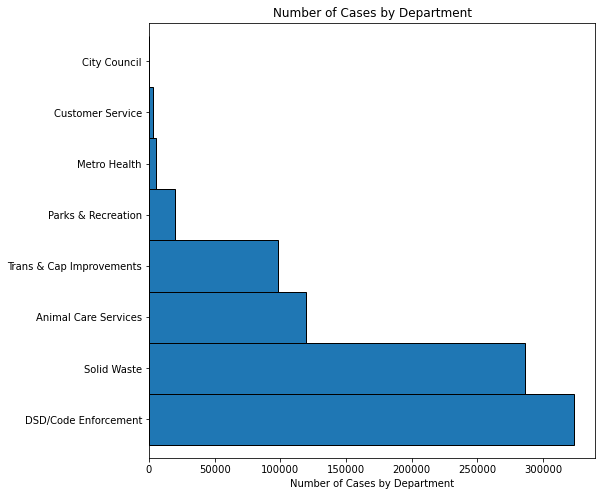

In [6]:
# How many different cases are there, by department?
(
    df.groupBy("standardized_dept_name")
      .agg(count("case_id").alias("number_of_cases"))
    
      .toPandas()
      .set_index("standardized_dept_name")
      .number_of_cases.sort_values(ascending=False)
      .plot.barh(width=1, edgecolor="black", figsize=(8,8))
)

plt.xlabel("Number of Cases by Department")
plt.ylabel("")
plt.title("Number of Cases by Department")

Text(0.5, 1.0, 'Percent of Cases Late by Department')

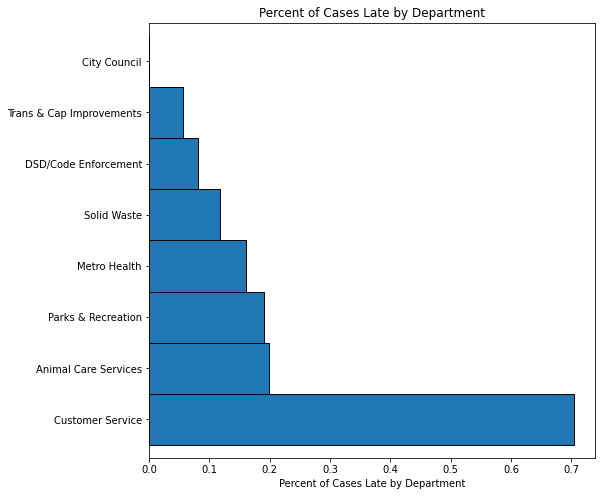

In [7]:
# Does the percentage of cases that are late vary by department?

df = (
    df.groupBy("standardized_dept_name")
      .pivot("case_late")
      .agg(count("case_id"))
      .na.fill(0)
      .toPandas()
      
      
)

df["TOTAL"]=(df.NO+df.YES)
df["PERCENT_LATE"]=(df.YES/df.TOTAL)

(
    df.set_index("standardized_dept_name")
      .PERCENT_LATE.sort_values(ascending=False)
      .plot.barh(width=1, edgecolor="black", figsize=(8,8))
)

plt.xlabel("Percent of Cases Late by Department")
plt.ylabel("")
plt.title("Percent of Cases Late by Department")



Text(0.5, 1.0, 'Average Days Late For Late Cases')

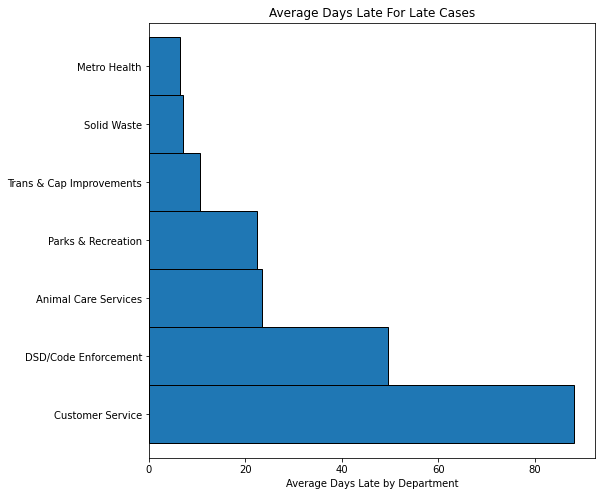

In [8]:
# On average, how late are the late cases by department?

df = spark.read.csv("wrangle_311", sep=",", header=True, inferSchema=True)

df = (
    df.filter(df.case_late=="YES")
      .groupBy("standardized_dept_name")
      .agg(avg("num_days_late").alias("days"))
      .toPandas()
      .set_index("standardized_dept_name")
      .days.sort_values(ascending=False)
      .plot.barh(width=1, edgecolor="black", figsize=(8,8))
)

plt.xlabel("Average Days Late by Department")
plt.ylabel("")
plt.title("Average Days Late For Late Cases")


In [10]:
# df = (
#     df.filter(df.case_late=="YES")
#       .groupBy("standardized_dept_name")
#       .agg(avg("num_days_late").alias("days"))
#       .toPandas()
#       .set_index("standardized_dept_name")
#       .days.sort_values(ascending=False)
#       .plot.barh(width=1, edgecolor="black", figsize=(8,8))
# )

In [22]:
df = spark.read.csv("wrangle_311", sep=",", header=True, inferSchema=True)
df.show(1,vertical=True)

-RECORD 0--------------------------------------
 source_username        | CRM_Listener         
 case_id                | 1014127597           
 case_opened_date       | 1/1/18 15:22         
 case_closed_date       | 1/1/18 19:59         
 SLA_due_date           | 1/3/18 8:30          
 case_late              | NO                   
 num_days_late          | -1.5212152780000001  
 case_closed            | YES                  
 dept_division          | Signals              
 service_request_type   | Traffic Signal Op... 
 SLA_days               | 1.713460648          
 case_status            | Closed               
 source_id              | CRM_Listener         
 request_address        | GEN MCMULLEN N an... 
 council_district       | 5                    
 standardized_dept_name | Trans & Cap Impro... 
 dept_subject_to_SLA    | YES                  
only showing top 1 row



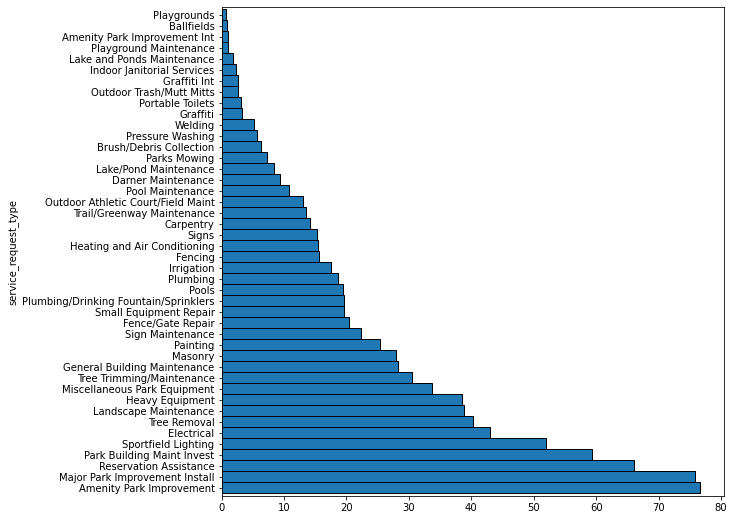

In [21]:
# What is the service type that is the most late? Just for Parks & Rec?

df = spark.read.csv("wrangle_311", sep=",", header=True, inferSchema=True)

df = (
        df.filter(df.case_late=="YES")
        .filter(df.standardized_dept_name=="Parks & Recreation")
        .groupBy("service_request_type").agg(avg("num_days_late").alias("days"))
        .toPandas()
        .set_index("service_request_type")
        .days.sort_values(ascending=False)
        .plot.barh(width=1, edgecolor="black", figsize=(9,9))
)



In [44]:
li = list(
    df.select('standardized_dept_name').toPandas()['standardized_dept_name']
)

li = set(li)

li

{'Animal Care Services',
 'City Council',
 'Customer Service',
 'DSD/Code Enforcement',
 'Metro Health',
 'Parks & Recreation',
 'Solid Waste',
 'Trans & Cap Improvements'}

Text(0.5, 1.0, 'Average Days Late For Animal Care Services')

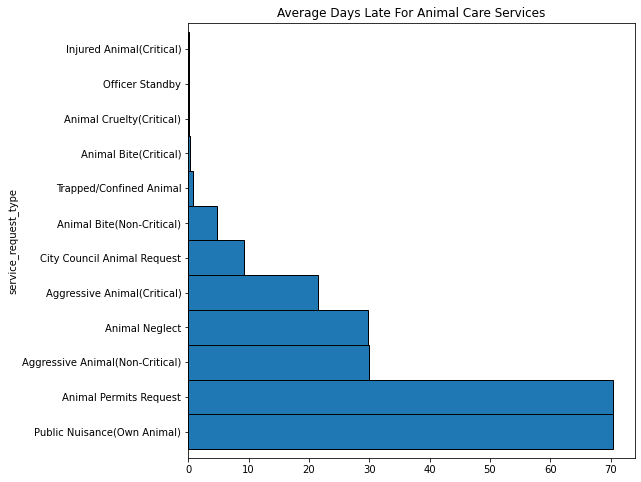

In [50]:
# For the DSD/Code Enforcement department, what are the most common service request types? standardized_dept_name
# Look at other departments too.

dept = 'Animal Care Services'

df = spark.read.csv("wrangle_311", sep=",", header=True, inferSchema=True)

df = (
        df.filter(df.case_late=="YES")
        .filter(df.standardized_dept_name==f"{dept}")
        .groupBy("service_request_type").agg(avg("num_days_late").alias("days"))
        .toPandas()
        .set_index("service_request_type")
        .days.sort_values(ascending=False)
        .plot.barh(width=1, edgecolor="black", figsize=(8,8))
)

plt.title(f"Average Days Late For {dept}")

In [ ]:
# Does whether or not its a weekend matter for when a case is opened/closed?

In [ ]:
# On average, how many cases are opened a day for the Customer Service department?



In [ ]:
# Does the number of service requests for the solid waste department vary by day of the week?